In [48]:
import sys
sys.path.append("../")
import PatternStructure as ps
import AssociativeNetwork as nt
import functions as fs
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
from tqdm import tqdm
sns.set(style='white',font_scale=1)

## Da fare
Fissare la transition matrix per confrontare diverse sigma

In [99]:
# PARAMETERS
GAMMA = 0.5
XI = 0.1
N_CELLS = 1000
N_PATTERNS = 16 # P
CELLS_PER_PATTERN = 100 
N_CHAINS = 2 # M
PATTERNS_PER_CHAIN = 2 # Q
SIGMAS = [0, 0.1, 0.3, 0.5, 0.8, 1, 2, 4]

DYNAMIC_SPARISTY = .2*(CELLS_PER_PATTERN/N_CELLS)

example_name = 0
sigma_idx = 5
output_dir = f'./sigma_imgs/sigma{SIGMAS[sigma_idx]}/example{example_name}' 
Path(output_dir).mkdir(parents=True, exist_ok=True)

In [100]:
#Memory structure
kernel = ps.InteractionKernel(gamma=GAMMA,xi=XI)
memories = ps.PatternStructure(n_cells=N_CELLS,
                            n_patterns=N_PATTERNS,
                            cells_per_pattern=CELLS_PER_PATTERN,
                            n_chains=N_CHAINS,
                            patterns_per_chain=PATTERNS_PER_CHAIN,
                            kernel=kernel)


memories.generate_patterns()
memories.generate_chains()
memories.build_interactions()

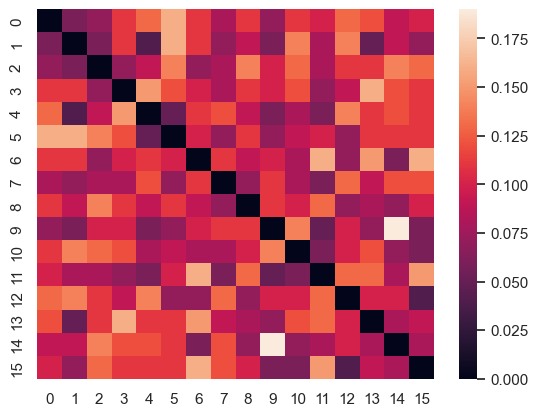

In [101]:
pattern_overlap = ps.pattern_overlap_matrix(memories)
sns.heatmap(pattern_overlap);

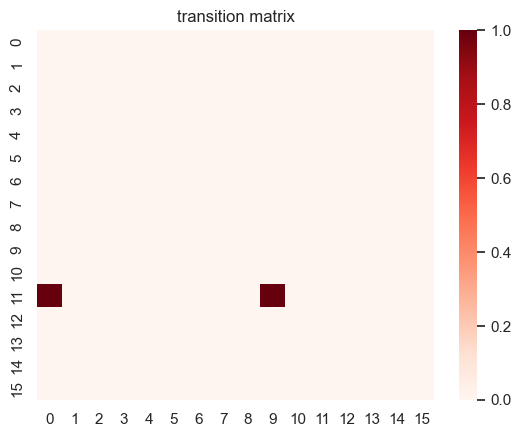

In [102]:
G = nx.from_numpy_matrix(memories.chain_transitions)
plt.title('transition matrix')
sns.heatmap(memories.chain_transitions,cmap=plt.cm.Reds)

plt.savefig(output_dir+f'/transitions')

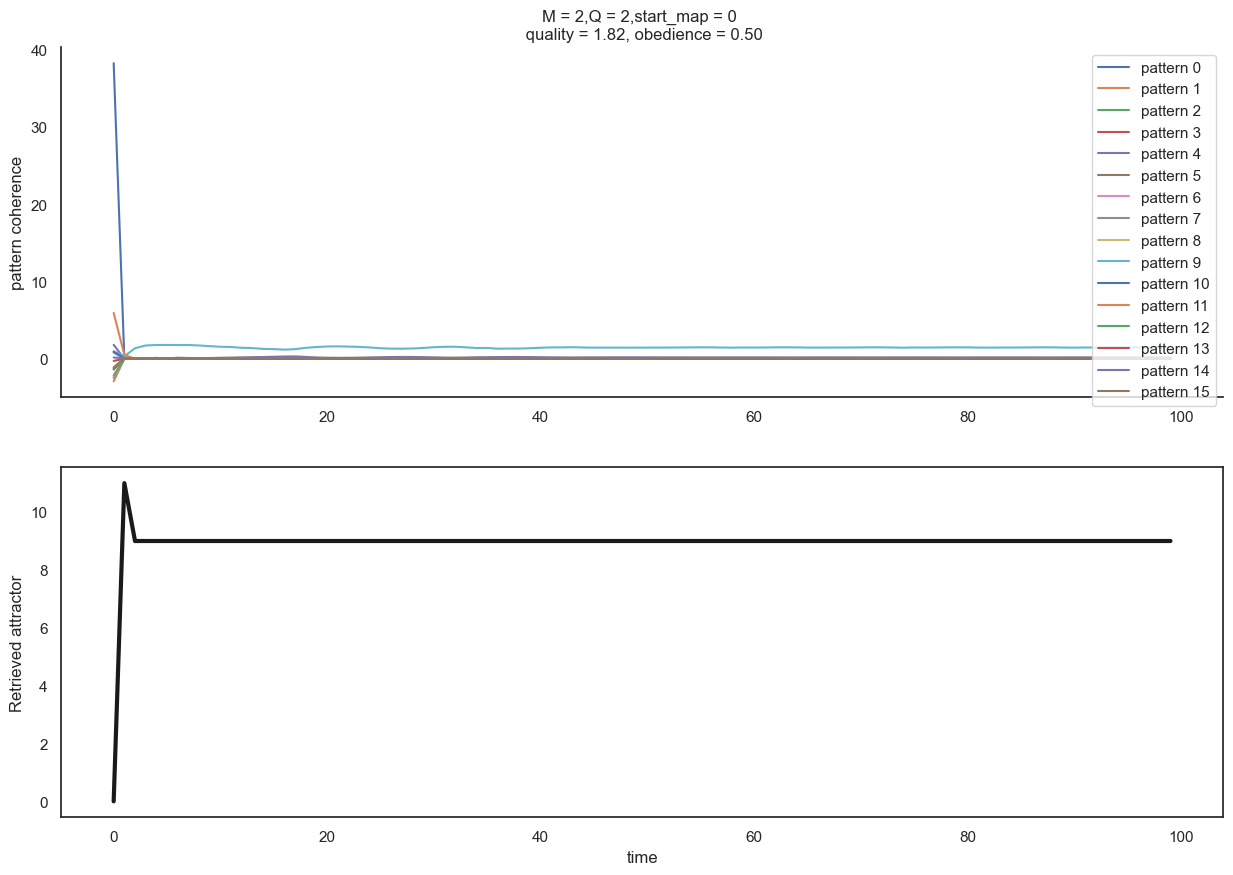

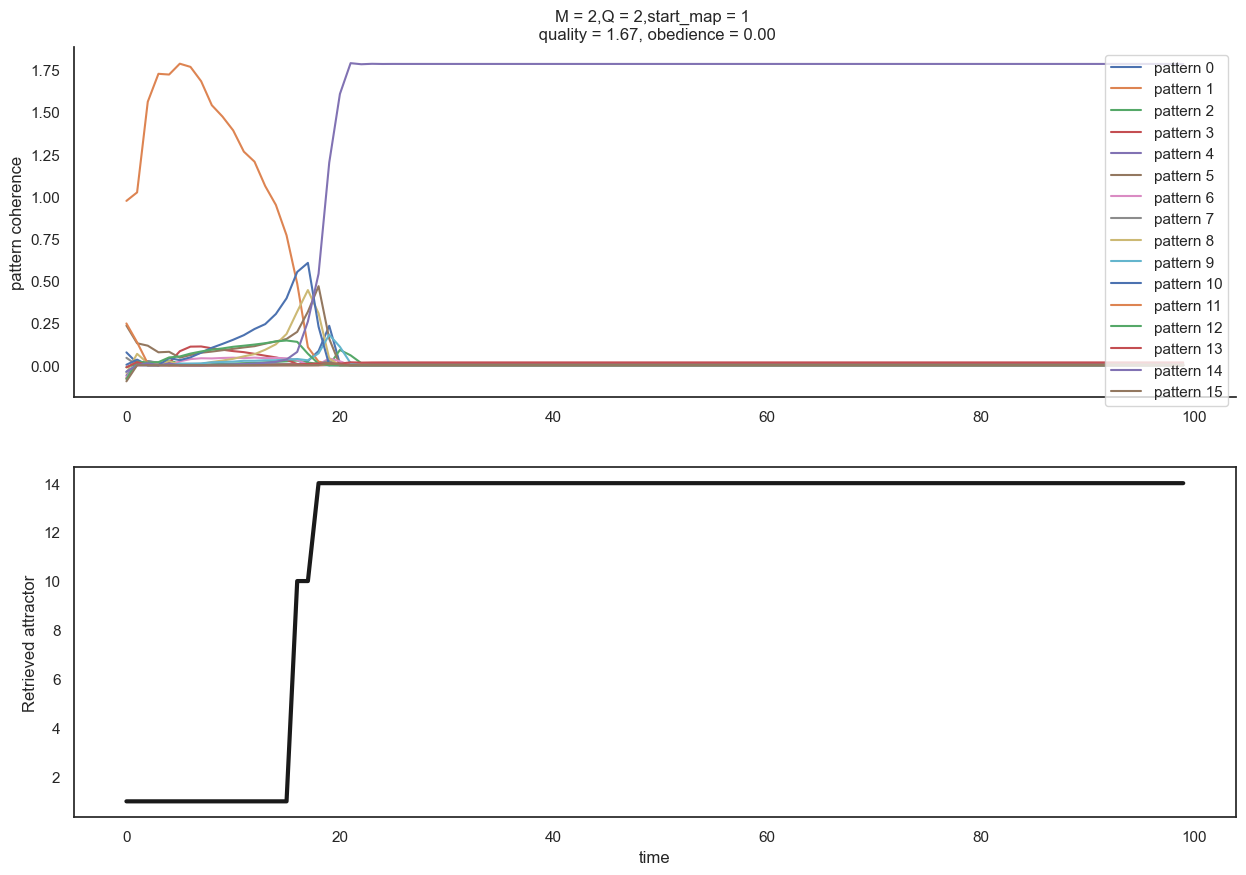

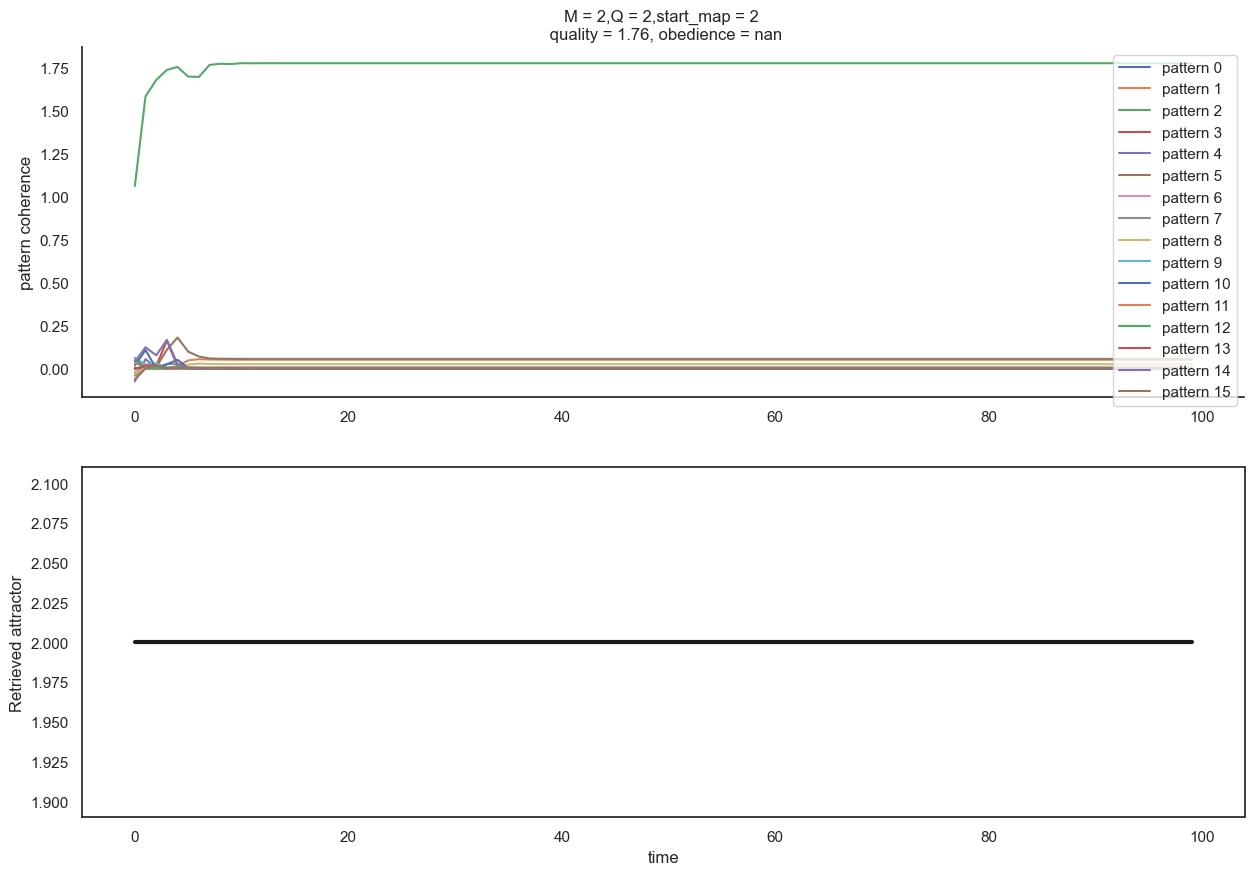

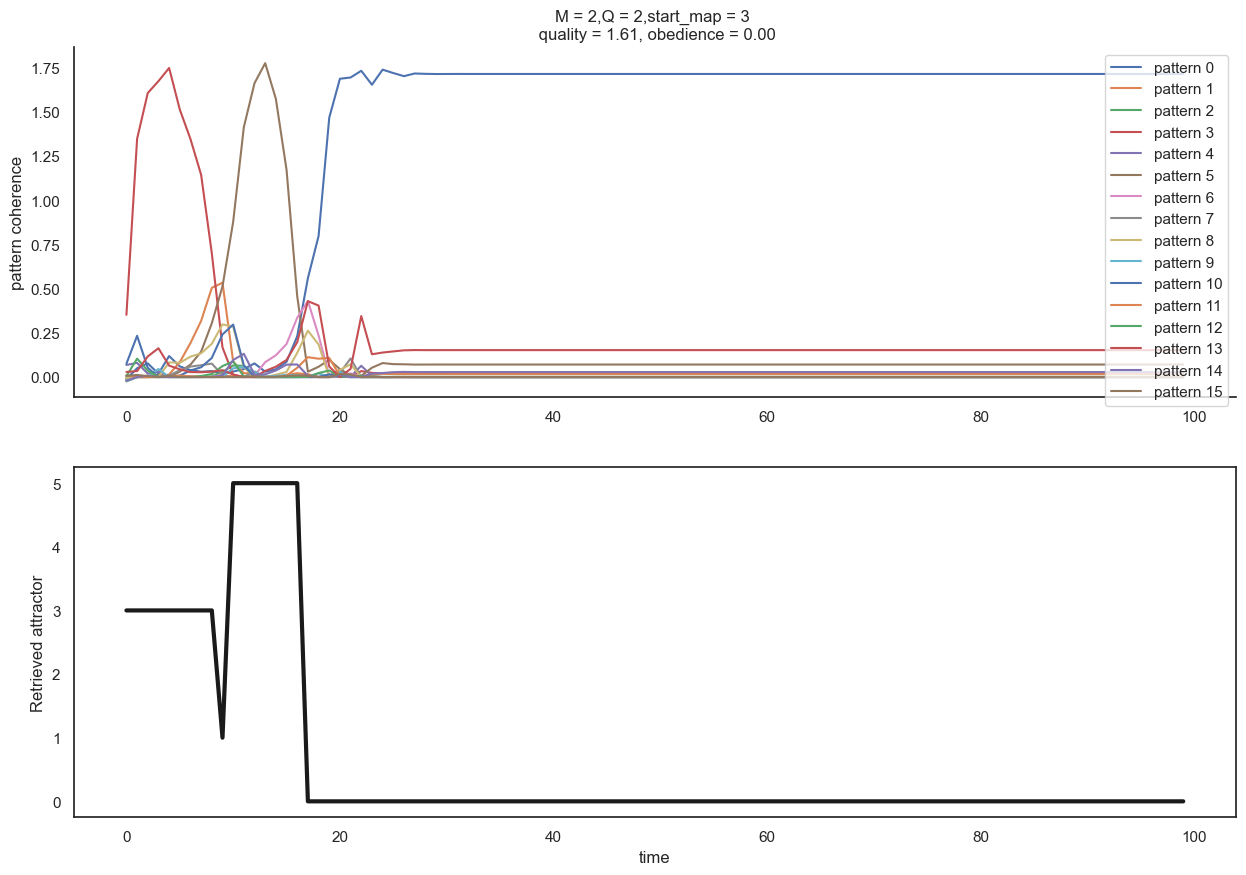

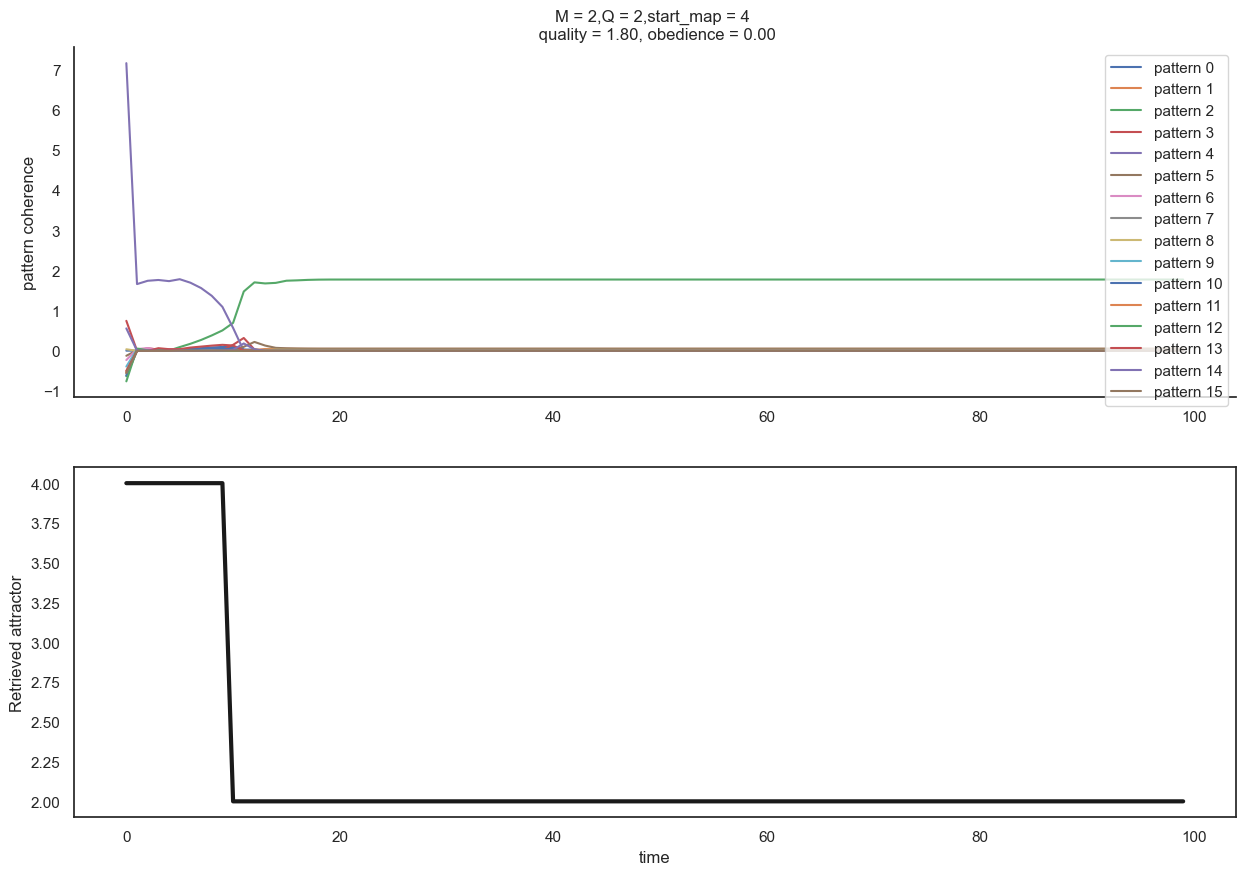

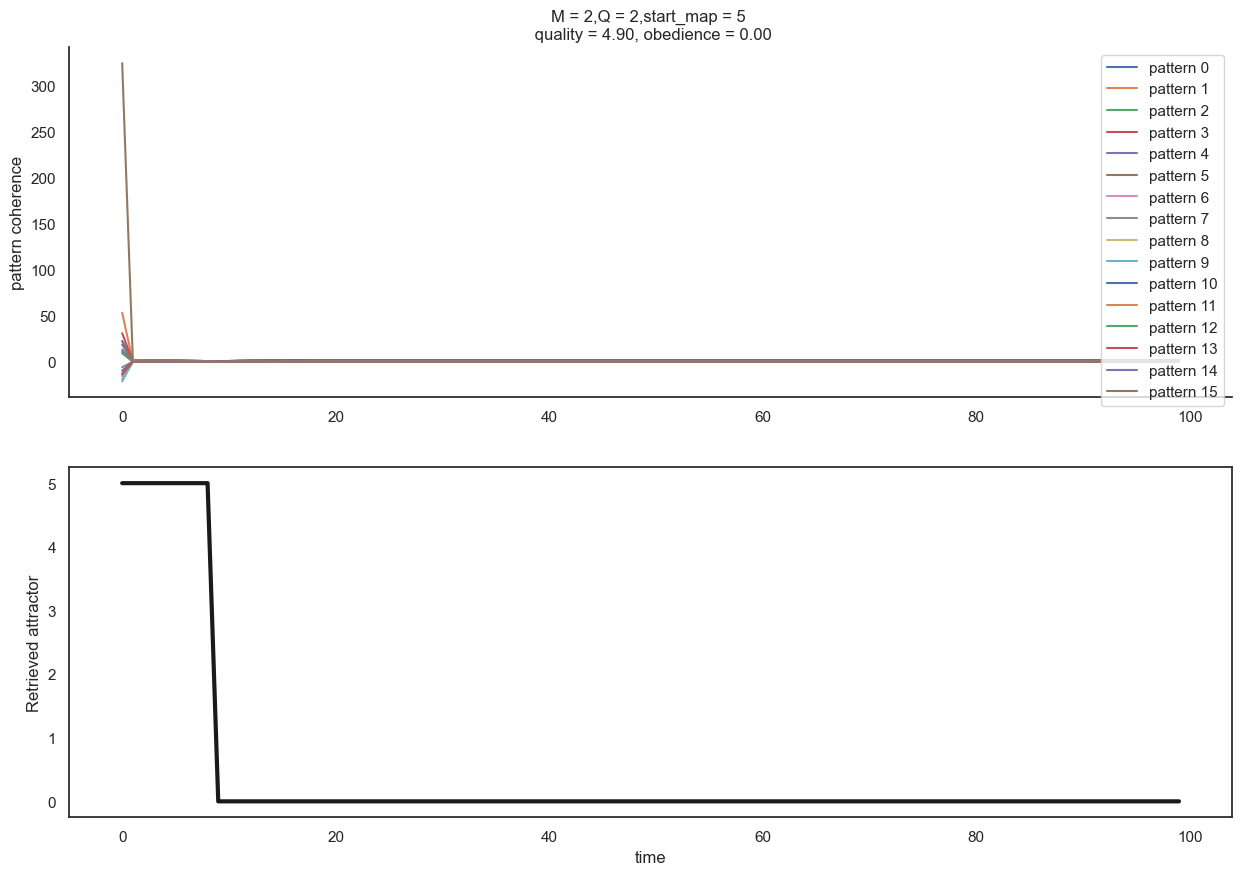

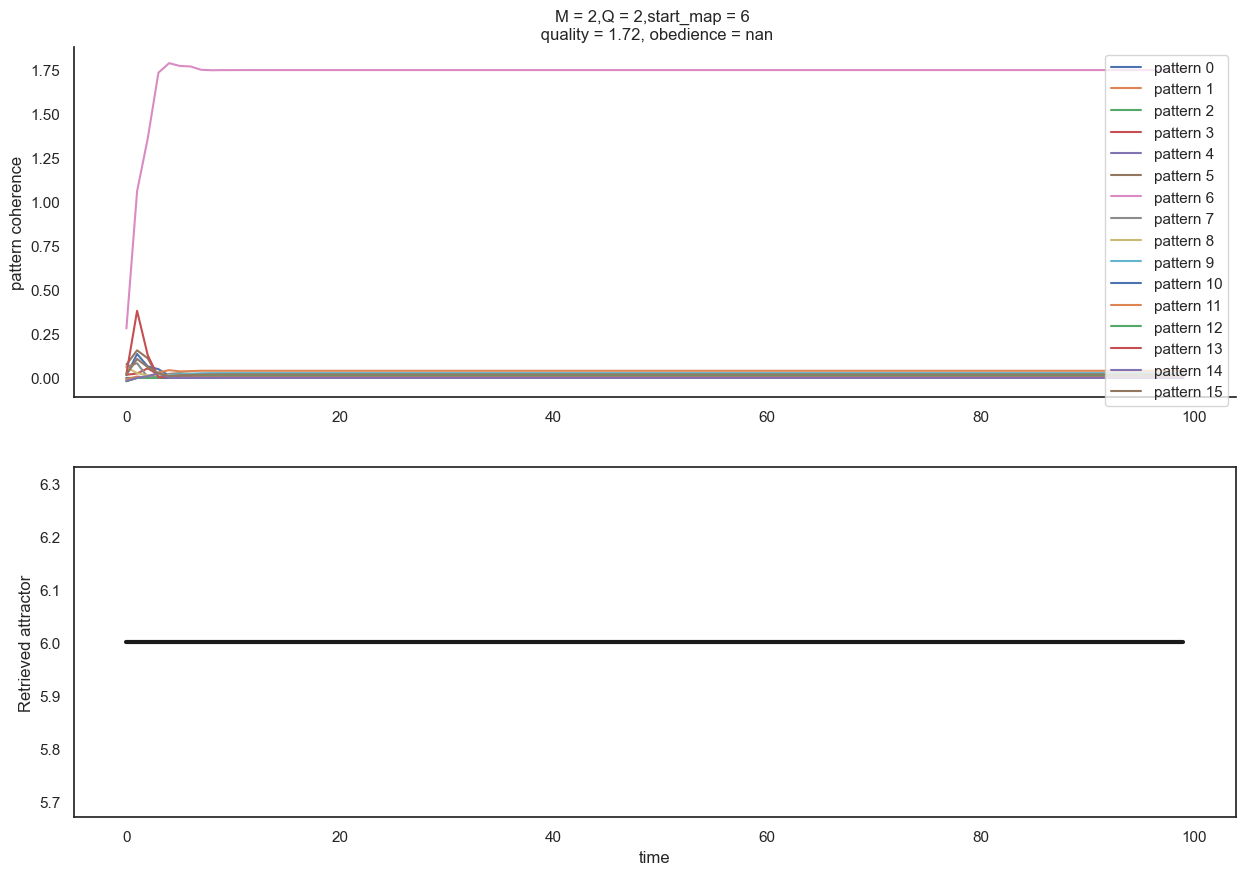

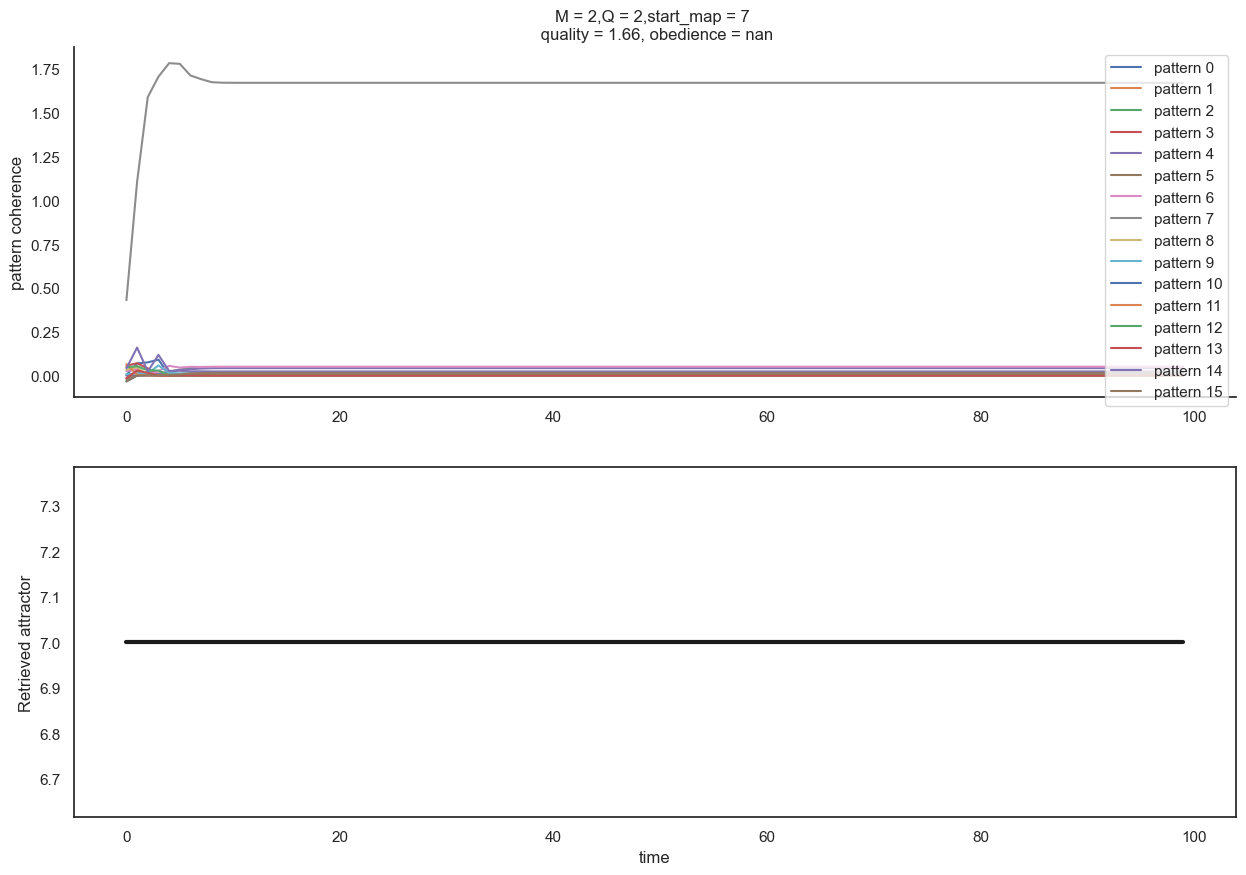

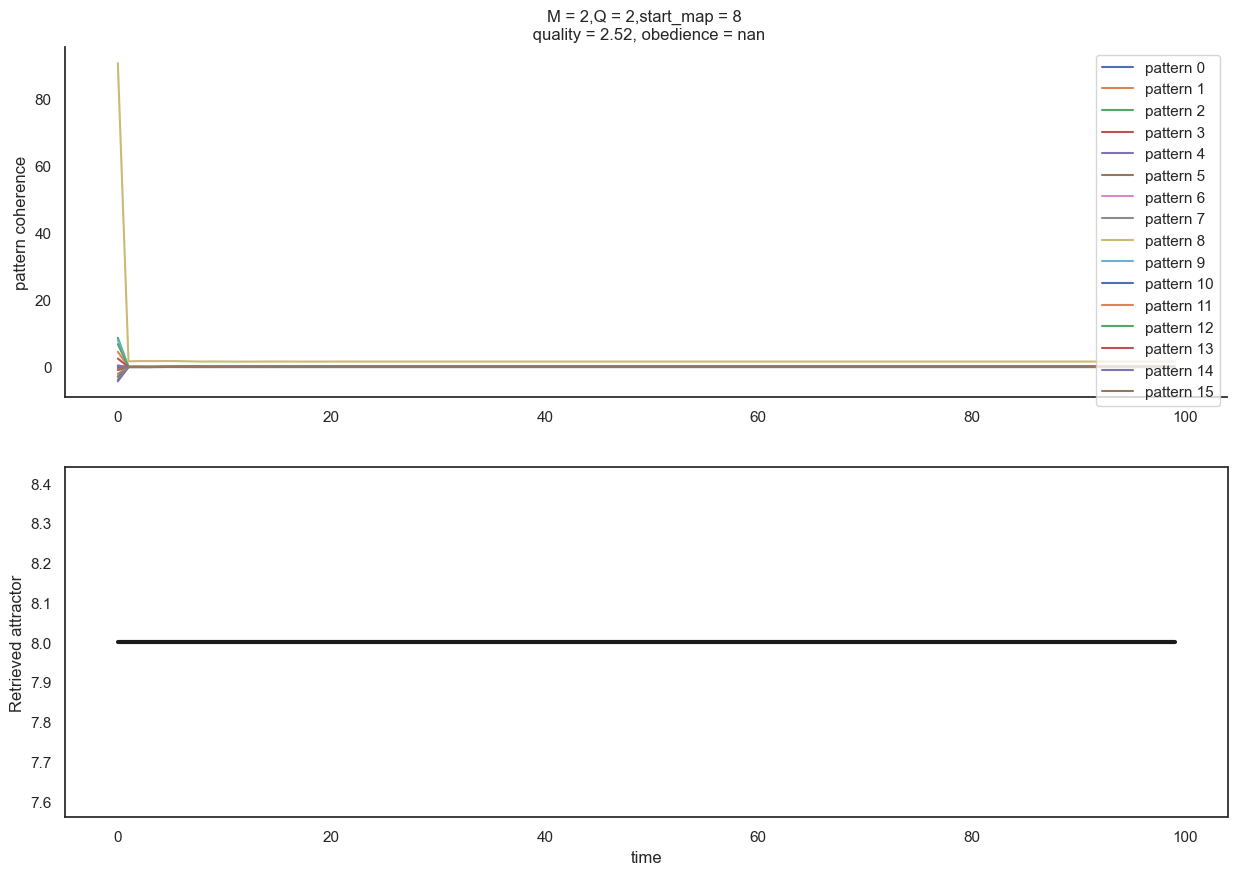

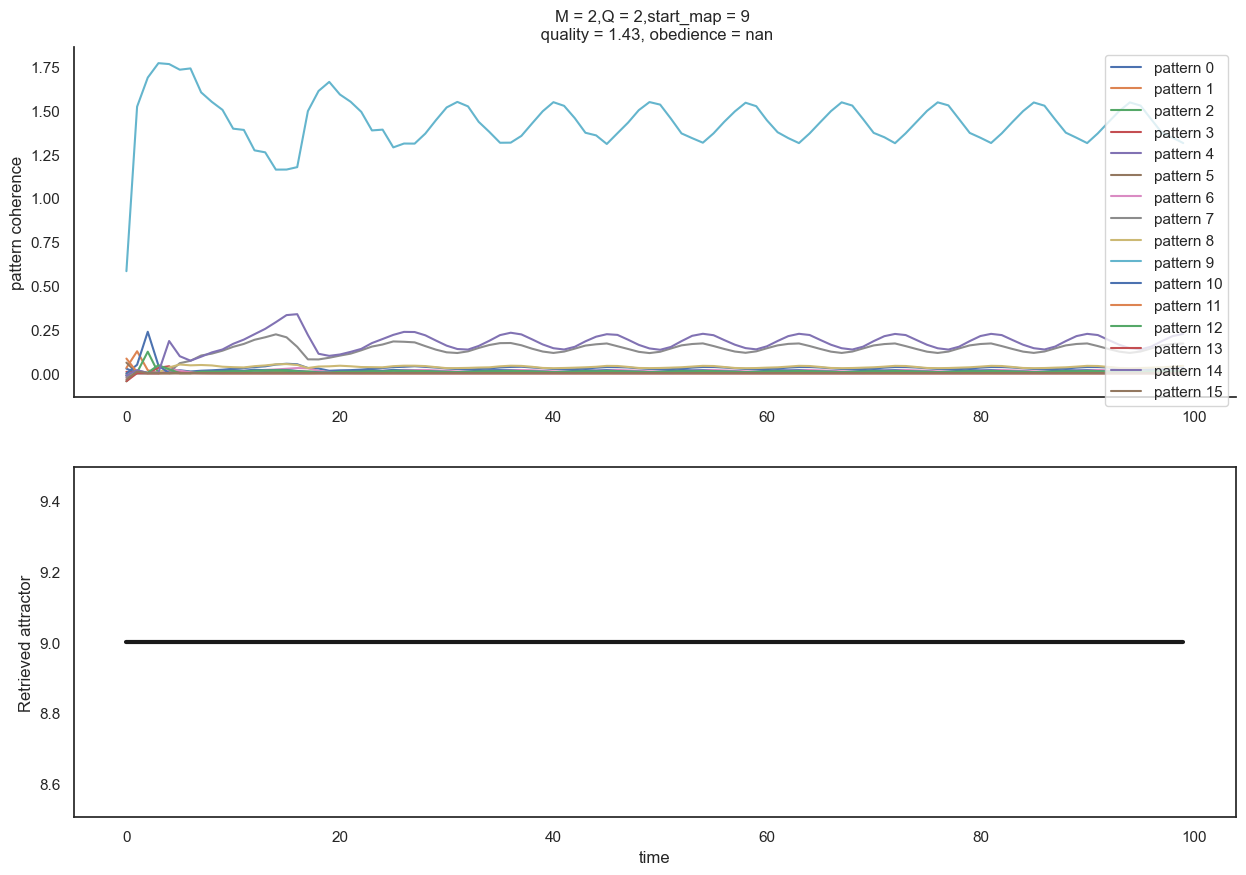

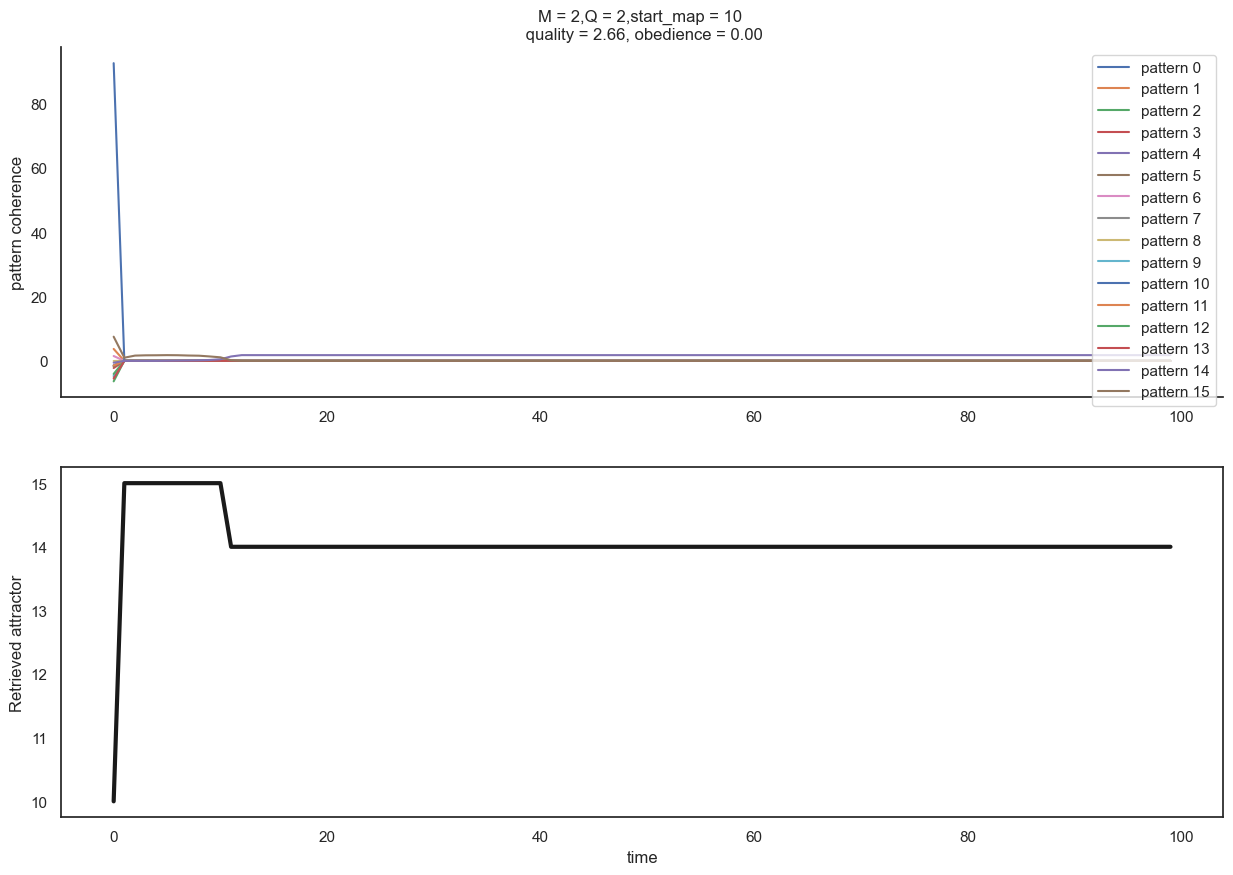

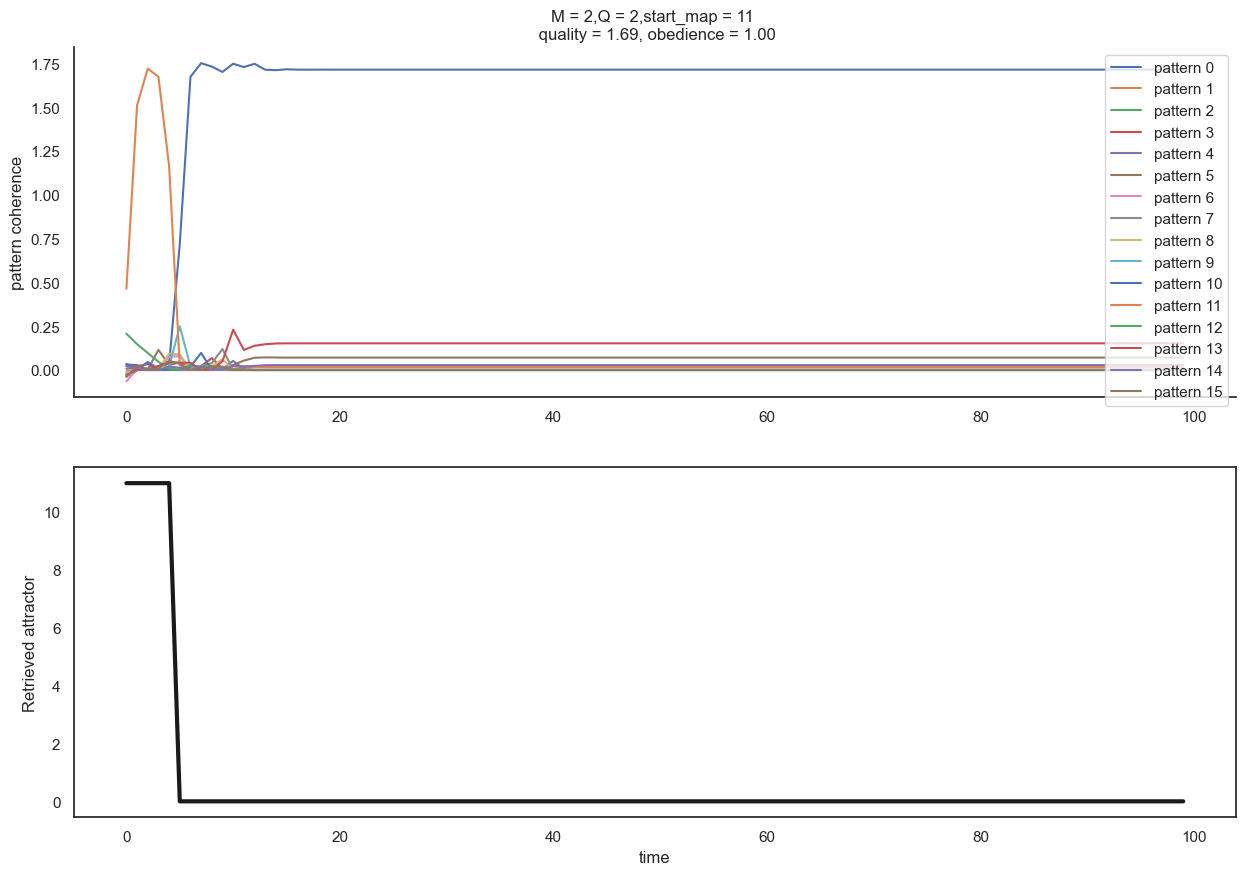

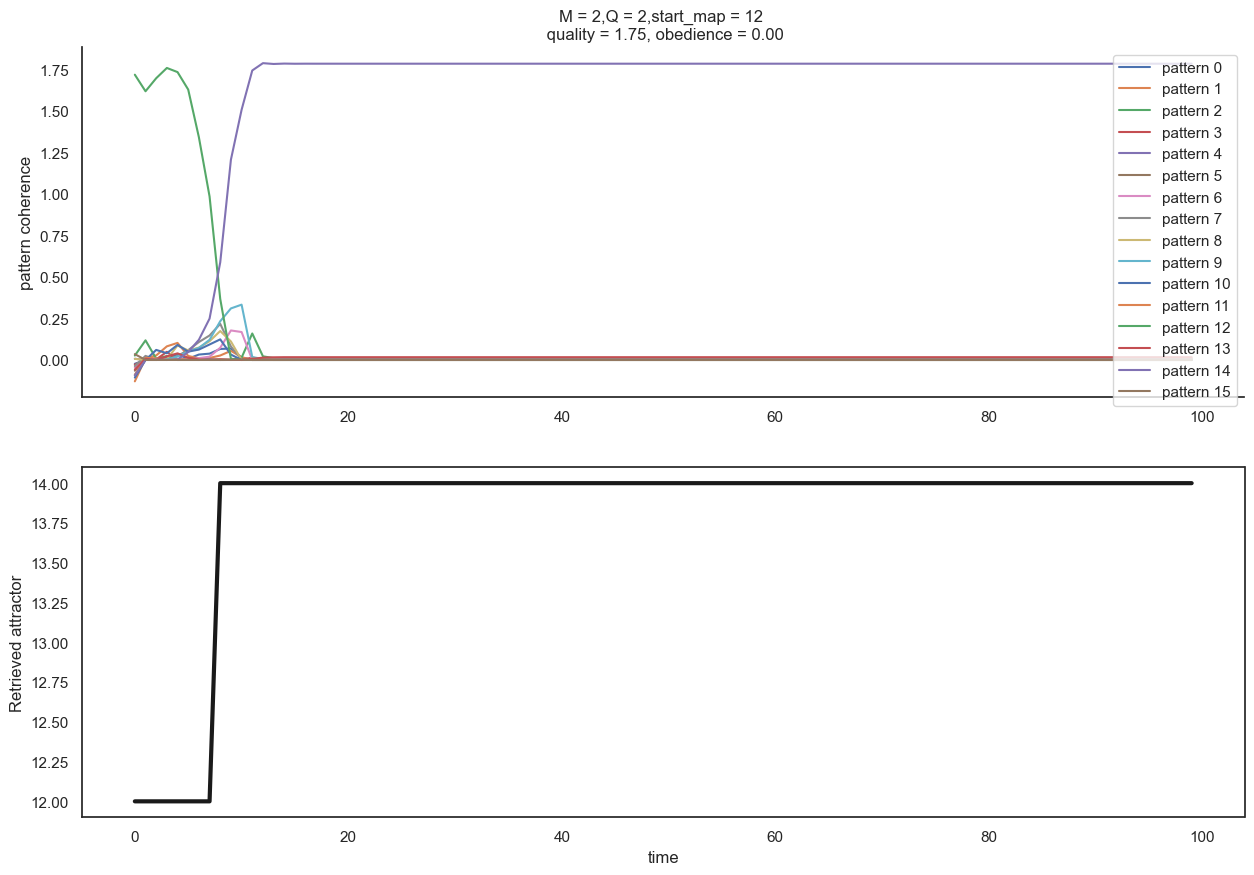

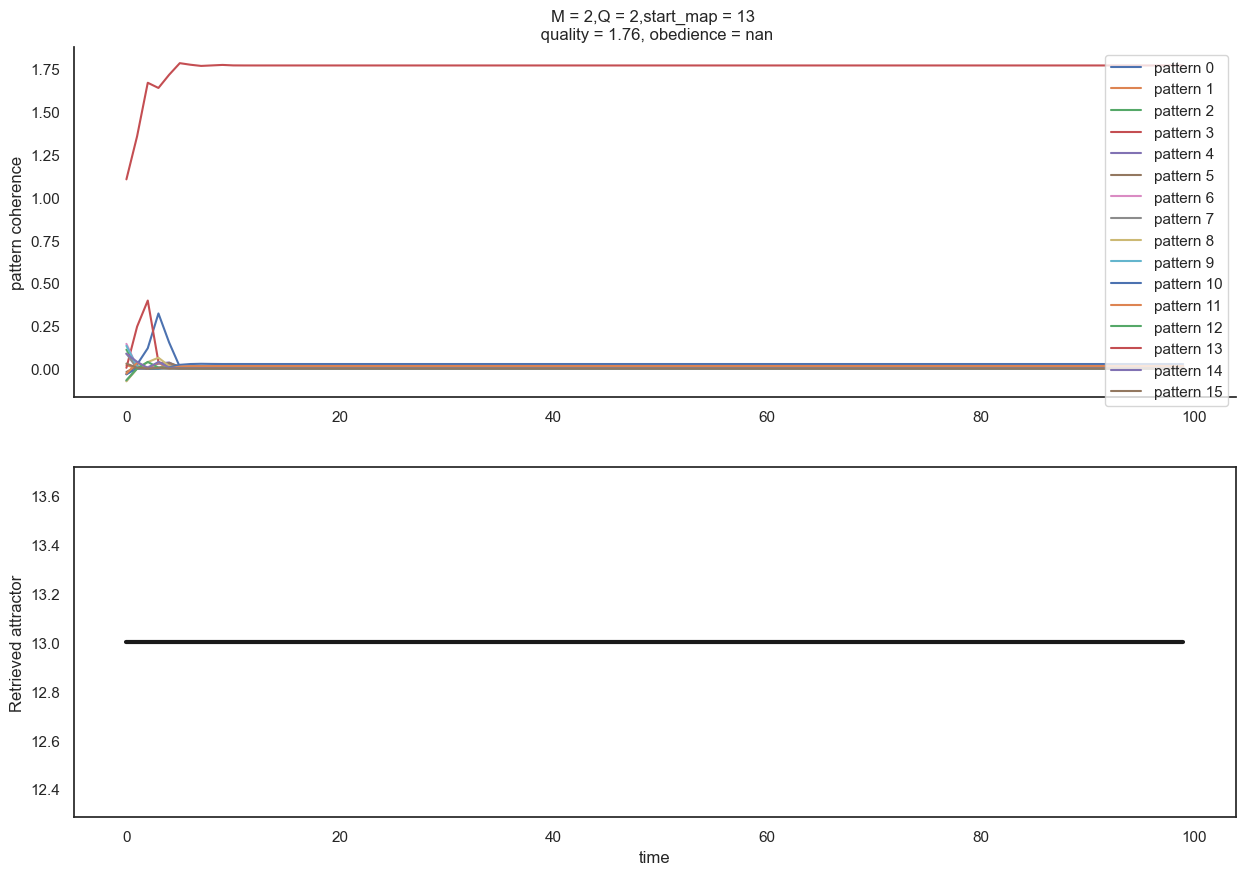

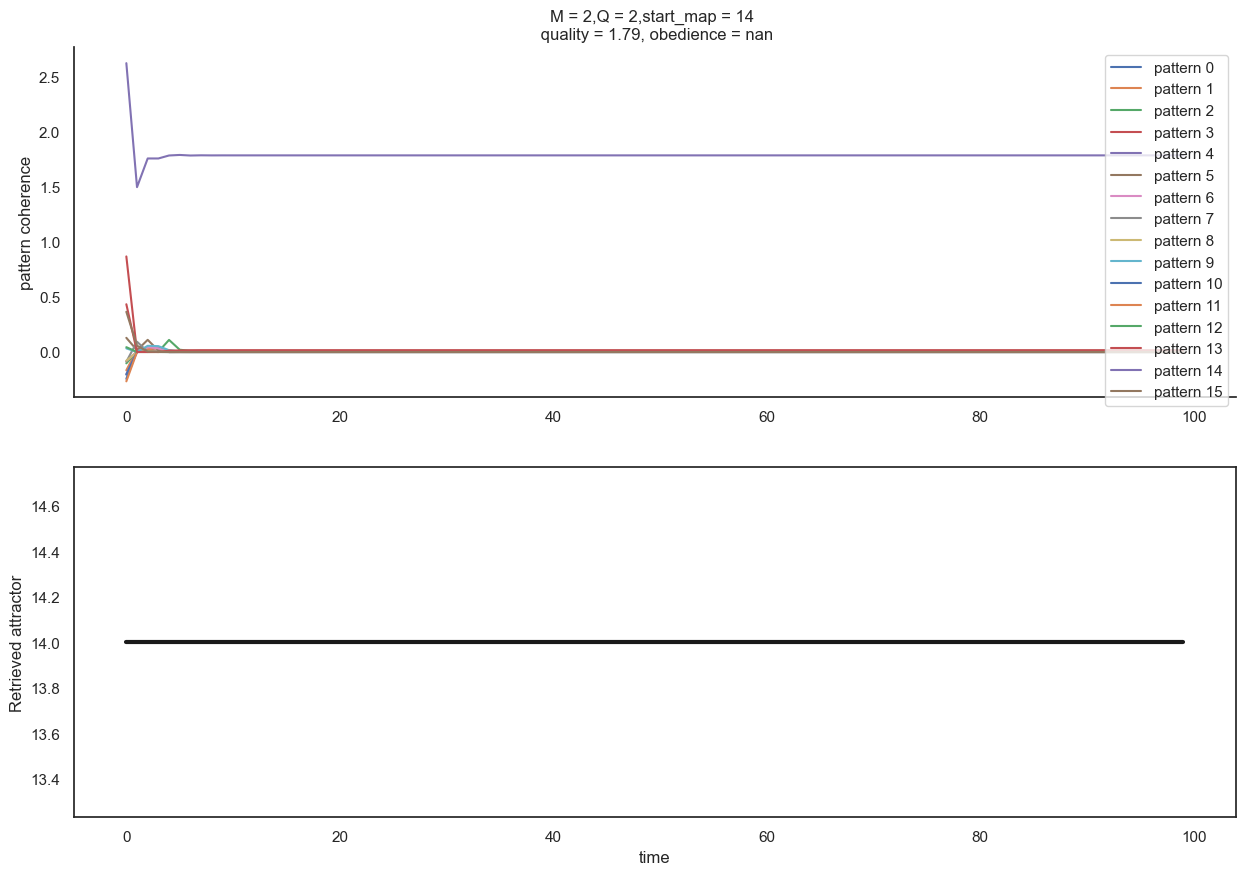

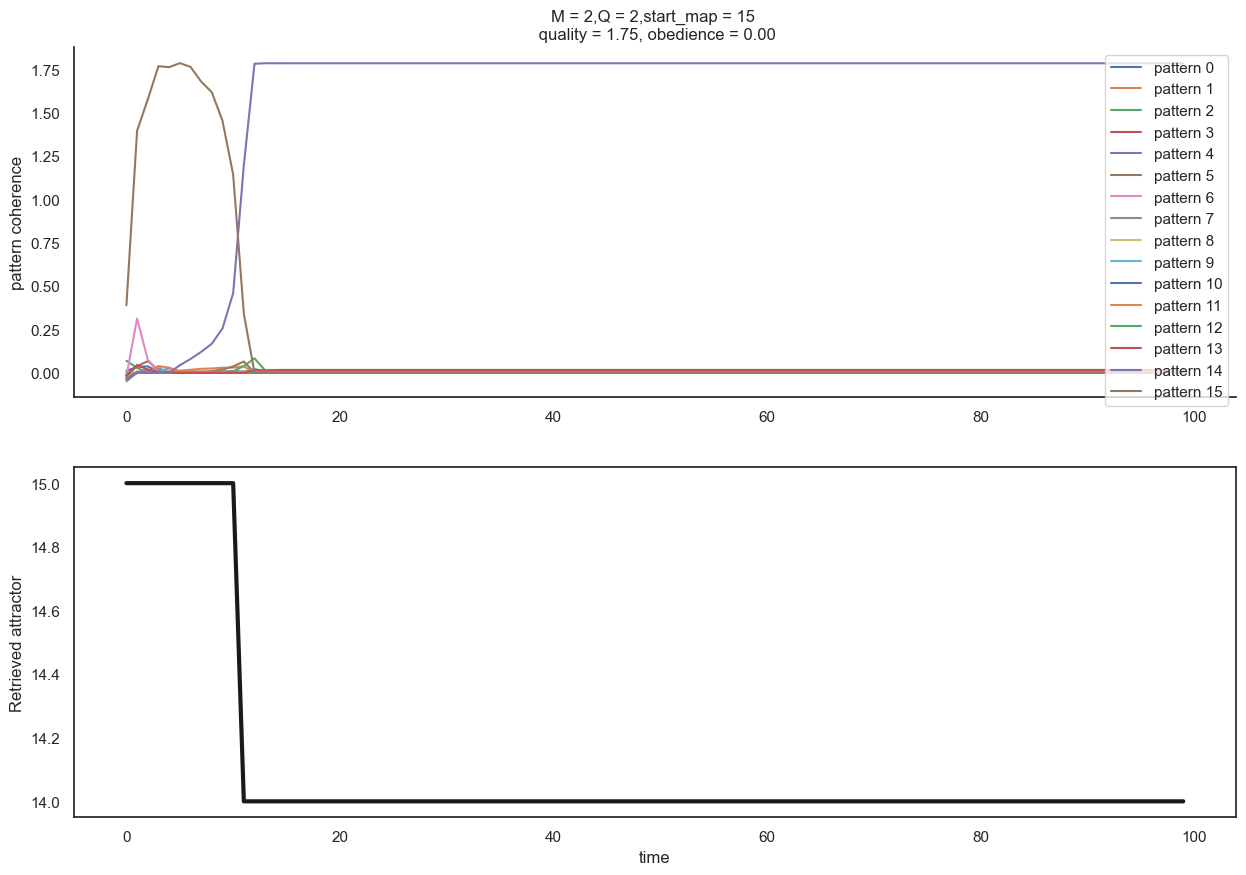

In [103]:
N_STEPS = 100 
N_STARTING_MAPS = N_PATTERNS

save_figs = True 

# starting_maps = np.random.choice(range(N_PATTERNS),N_STARTING_MAPS)
starting_maps = range(N_PATTERNS)
Coherence = []
Sequences = []
Coherence_start_specific = []

for dyn,starting_map in enumerate(starting_maps):

    net = nt.Network(J=memories.interaction_matrix, 
                 transfer_func=nt.ReLu,
                 dynamic_func=nt.net_dynamics)

    initial_config = ps.build_correlated_activity(memories,starting_map,position=0.1, sigma=SIGMAS[sigma_idx])
    initial_config = initial_config/np.mean(initial_config)
    net.run_dynamics(initial_config,n_steps=N_STEPS,sparsity=DYNAMIC_SPARISTY)

    coherence = fs.coherence_timecourse(memories,net.history)
    attractors = fs.attractors_timecourse(memories,net.history)
    retrieved_sequence = fs.retrieved_sequence(memories,net.history)

    retrieval_quality = fs.compute_retrieval_quality(coherence)
    obedience = fs.compute_obedience(retrieved_sequence,memories.chain_transitions)

    #coherence with starting map 
    coherence_wstart = np.mean(coherence[dyn]) 

    Coherence.append(coherence)
    # Sequences[dyn] = retrieved_sequence
    Coherence_start_specific.append(coherence_wstart)

    plt.figure(figsize=(15,10))
    plt.subplot(2,1,1)
    for i,timecourse in enumerate(coherence):
        plt.plot(timecourse,label=f'pattern {i}')
    plt.legend()

    sns.despine()
    plt.title(f'M = {N_CHAINS},Q = {PATTERNS_PER_CHAIN},start_map = {starting_map} \n quality = {retrieval_quality:.2f}, obedience = {obedience:.2f}')
    plt.ylabel('pattern coherence')

    plt.subplot(2,1,2)
    plt.plot(attractors,c='k',linewidth=3)
    plt.xlabel('time')
    plt.ylabel('Retrieved attractor')

    if save_figs: plt.savefig(output_dir+f'/dynamics{dyn}')



In [104]:
Coherence_start_specific

[0.4087435747939566,
 0.22522473639878726,
 1.761530885512791,
 0.1354162176688146,
 0.2213901307430583,
 3.4298375447244176,
 1.7223322748000214,
 1.6558928225815106,
 2.5237638045690294,
 1.431549775895728,
 0.9252984873955841,
 0.08040105405125704,
 0.12856365761928612,
 1.7574410644200433,
 1.7893915543663075,
 0.16671793631679524]

# IDEAS
---
## ORDER PARAMETERS:
We want to quantify:
- intermittent retrieval: instead of average quality, fraction of times in which quality is above threshold
- Entropy of the produced sequence: 


## MEMORY NETWORK FEATURES:
How do different network metrics influence the behaviour of the memories?
- Number of intersections (Out/In degree?)
- 